### filter transmission profiles here: http://www.ias.u-psud.fr/virgo/virgo%20new/

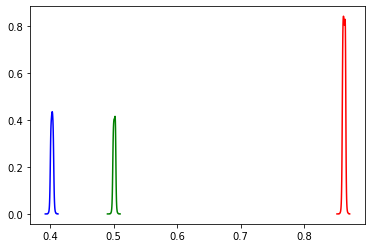

In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

tr, tg, tb = (np.loadtxt('soho/virspmred.dat').T, 
              np.loadtxt('soho/virspmgrn.dat').T, 
              np.loadtxt('soho/virspmblu.dat').T)

pl.plot(tr[0]/1e3, tr[1], 'r')
pl.plot(tg[0]/1e3, tg[1], 'g')
pl.plot(tb[0]/1e3, tb[1], 'b')

### Grab some Phoenix spectra from the JexoSim archive:

In [2]:
from astropy.io import fits
spec_mean = fits.open('../JexoSim/archive/BT-Settl_M-0.0a+0.0/lte058.0-4.5-0.0a+0.0.BT-Settl.spec.fits.gz')
spec_cold = fits.open('../JexoSim/archive/BT-Settl_M-0.0a+0.0/lte058.0-4.5-0.0a+0.0.BT-Settl.spec.fits.gz')
spec_hot = fits.open('../JexoSim/archive/BT-Settl_M-0.0a+0.0/lte062.0-4.5-0.0a+0.0.BT-Settl.spec.fits.gz')

In [3]:
wlc = spec_cold[1].data.field('wavelength')
wlh = spec_hot[1].data.field('wavelength')
fc = spec_cold[1].data.field('flux')
fh = spec_hot[1].data.field('flux')

In [4]:
from scipy.interpolate import interp1d
interp_transmission_r = interp1d(tr[0]/1e3, tr[1])
interp_transmission_g = interp1d(tg[0]/1e3, tg[1])
interp_transmission_b = interp1d(tb[0]/1e3, tb[1])
interp_spec_hot = interp1d(wlh, fh)
interp_spec_cold = interp1d(wlc, fc)

int_hot_r = lambda x: interp_transmission_r(x)*interp_spec_hot(x)
int_cold_r = lambda x: interp_transmission_r(x)*interp_spec_cold(x)

int_hot_g = lambda x: interp_transmission_g(x)*interp_spec_hot(x)
int_cold_g = lambda x: interp_transmission_g(x)*interp_spec_cold(x)

int_hot_b = lambda x: interp_transmission_b(x)*interp_spec_hot(x)
int_cold_b = lambda x: interp_transmission_b(x)*interp_spec_cold(x)

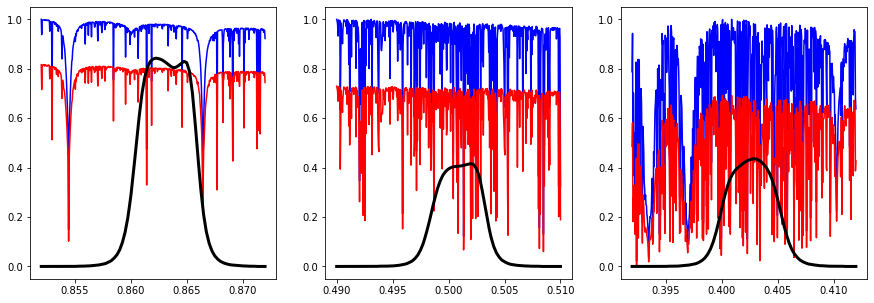

In [5]:
fig, ax = pl.subplots(1, 3, figsize=(15, 5))
x_r, x_g, x_b = (np.linspace(np.min(tr[0]/1e3), np.max(tr[0]/1e3), 500),
                np.linspace(np.min(tg[0]/1e3), np.max(tg[0]/1e3), 500),
                np.linspace(np.min(tb[0]/1e3), np.max(tb[0]/1e3), 500))

ax[0].plot(x_r, interp_spec_hot(x_r)/np.max(interp_spec_hot(x_r)), 'b')
ax[0].plot(x_r, interp_spec_cold(x_r)/np.max(interp_spec_hot(x_r)), 'r')
ax[0].plot(x_r, interp_transmission_r(x_r), 'k', linewidth=3)

ax[1].plot(x_g, interp_spec_hot(x_g)/np.max(interp_spec_hot(x_g)), 'b')
ax[1].plot(x_g, interp_spec_cold(x_g)/np.max(interp_spec_hot(x_g)), 'r')
ax[1].plot(x_g, interp_transmission_g(x_g), 'k', linewidth=3)

ax[2].plot(x_b, interp_spec_hot(x_b)/np.max(interp_spec_hot(x_b)), 'b')
ax[2].plot(x_b, interp_spec_cold(x_b)/np.max(interp_spec_hot(x_b)), 'r')
ax[2].plot(x_b, interp_transmission_b(x_b), 'k', linewidth=3)

In [6]:
from scipy.integrate import quad
flux_hot_r = quad(int_hot_r, np.min(tr[0])/1e3, np.max(tr[0])/1e3)
flux_cold_r = quad(int_cold_r, np.min(tr[0])/1e3, np.max(tr[0])/1e3)

flux_hot_g = quad(int_hot_g, np.min(tg[0])/1e3, np.max(tg[0])/1e3)
flux_cold_g = quad(int_cold_g, np.min(tg[0])/1e3, np.max(tg[0])/1e3)

flux_hot_b = quad(int_hot_b, np.min(tb[0])/1e3, np.max(tb[0])/1e3)
flux_cold_b = quad(int_cold_b, np.min(tb[0])/1e3, np.max(tb[0])/1e3)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps 

In [7]:
alpha_1 = (flux_hot_r[0] - flux_cold_r[0]) / flux_cold_r[0]
alpha_2 = (flux_hot_g[0] - flux_cold_g[0]) / flux_cold_g[0]
alpha_3 = (flux_hot_b[0] - flux_cold_b[0]) / flux_cold_b[0]

### Let's take a look at the SOHO data

In [8]:
from astropy.time import Time

blue = fits.open('soho/blue.fits')
green = fits.open('soho/green.fits')
red = fits.open('soho/red.fits')

rgb = red, green, blue

rgb = [f[0].data for f in rgb]
mask = np.all([np.isfinite(f) for f in rgb], axis=0)

start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, np.shape(rgb)[1]) - start

t = t[mask]
rgb = [f[mask].astype('float64') for f in rgb]
flux = np.sum(rgb, axis=0)/np.shape(rgb)[0]

# choose an arbitrary starting index and number of points to 
# select a segment of the (very large) SOHO timeseries 
i = 18273
n = 2000
t = t[i:i+n] - np.mean(t[i:i+n])

# in parts per part 
rgb = [f[i:i+n]/1e6 for f in rgb]

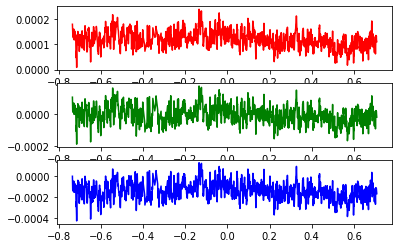

In [9]:
fig, ax = pl.subplots(3, 1)
ax[0].plot(t, rgb[0], 'r')
ax[1].plot(t, rgb[1], 'g')
ax[2].plot(t, rgb[2], 'b')

#[x.set_ylim(-0.5, 0.5) for x in ax]

In [10]:
(1 - rgb[0]/flux_cold_r[0])/alpha_1

array([4.37334995, 4.37334995, 4.37334995, ..., 4.37334995, 4.37334995,
       4.37334995])

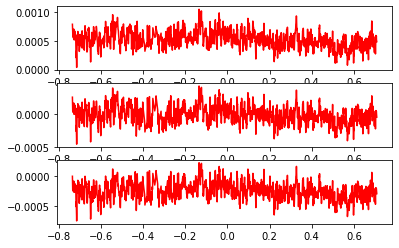

In [11]:
fig, ax = pl.subplots(3, 1)
ax[0].plot(t, rgb[0]/alpha_1, 'r')
ax[1].plot(t, rgb[1]/alpha_2, 'r')
ax[2].plot(t, rgb[2]/alpha_3, 'r')

#[x.set_ylim(-2, 2) for x in ax]

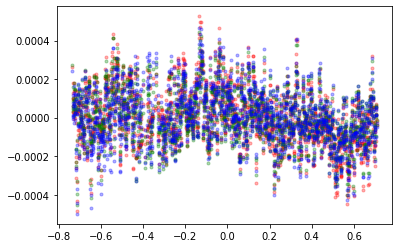

In [12]:
xr = rgb[0]

pl.plot(t, xr - np.mean(xr), 'r.', alpha=0.3)
pl.plot(t, xg - np.mean(xg), 'g.', alpha=0.3)
pl.plot(t, xb - np.mean(xb), 'b.', alpha=0.3)

### Looks good I guess! Let's fit a GP to the covering fraction so that we can use that to make up some variability for our targets. 

In [13]:
from scipy.optimize import minimize
import celerite2
from celerite2 import terms

x = xb

granulation_term = terms.SHOTerm(S0=5e-10, w0=1e3, Q=1/np.sqrt(2))
gp = celerite2.GaussianProcess(granulation_term, mean=0.0)
yerr = 20 * 1e-6

def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(S0=theta[0], w0=theta[1], Q=1/np.sqrt(2))
    gp.compute(t, diag = yerr ** 2 + theta[2], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(np.array(x))

initial_params = [0.0, np.log(5e-10), np.log(1e3), np.log(1e-6)]
print(neg_log_like(initial_params, gp))
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
print(soln)
print(np.exp(soln.x[1:]))

-11695.22241709466
      fun: -16435.913106708143
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.36967026e+01, -4.03815648e-02,  9.09494702e-03,  6.91215973e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 300
      nit: 49
   status: 0
  success: True
        x: array([-2.50272138e-04, -2.41642597e+01,  6.78684570e+00, -3.14102671e+01])
[3.20328348e-11 8.86114078e+02 2.28399068e-14]


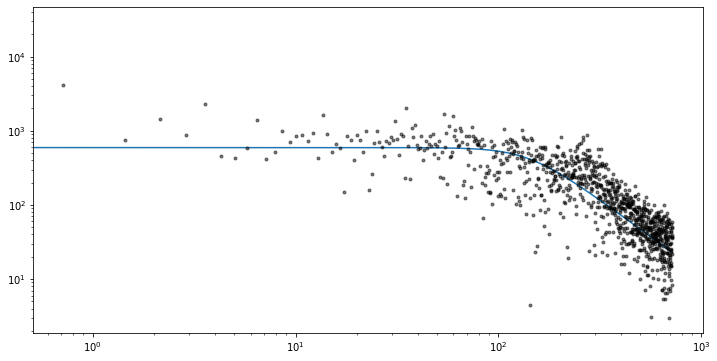

In [14]:
f = np.fft.rfftfreq(len(x), t[1] - t[0])
fft = np.fft.rfft(x)
fft = fft*np.conj(fft)
powerfft = fft.real / len(t)**2
ampfft = np.sqrt(powerfft * (60 * 60 * 24) / (2*np.pi)) * 1e6

psd = opt_gp.kernel.terms[0].get_psd(2*np.pi*f)
psd_amp = np.sqrt(psd * (60*60*24) / (2*np.pi)) * 1e6

pl.figure(figsize=(12, 6))
pl.loglog(f, psd_amp, '-')
pl.loglog(f, ampfft, 'k.', alpha=0.5)
#pl.ylim(1, 1e4)

In [25]:
t = np.linspace(0, 50000, 50000) / (60*60*24)
mean_temp = 4500
cold_temp = 4700
hot_temp = 4900

spec_num = lambda x: str(np.int(np.round(x/100)))

# generate a realization of the covering fraction GP 
params = [0.0, -2.26671849e+01,  6.82128886e+00, -np.inf]
term = terms.SHOTerm(S0=0, w0=0, Q=0)
gp = celerite2.GaussianProcess(term, mean=0.0)
gp = set_params(params, gp)
xc = gp.dot_tril(y = np.random.randn(len(t))) + 0.5

# get the spectra
spec_mean = fits.open('../JexoSim/archive/BT-Settl_M-0.0a+0.0/lte0' + spec_num(mean_temp) + '.0-4.5-0.0a+0.0.BT-Settl.spec.fits.gz')
spec_cold = fits.open('../JexoSim/archive/BT-Settl_M-0.0a+0.0/lte0' + spec_num(cold_temp) + '.0-4.5-0.0a+0.0.BT-Settl.spec.fits.gz')
spec_hot = fits.open('../JexoSim/archive/BT-Settl_M-0.0a+0.0/lte0' + spec_num(hot_temp) + '.0-4.5-0.0a+0.0.BT-Settl.spec.fits.gz')

wlm = spec_mean[1].data.field('wavelength')
wlc = spec_cold[1].data.field('wavelength')
wlh = spec_hot[1].data.field('wavelength')
fm = spec_mean[1].data.field('flux')
fc = spec_cold[1].data.field('flux')
fh = spec_hot[1].data.field('flux')

st = np.where(np.isclose(wlm, 0.6))[0][0]
end = np.where(np.isclose(wlm, 5.3))[0][1]
wl = np.linspace(wlm[st], wlm[end], 1000)

fm_interp = interp1d(wlm, fm)
fc_interp = interp1d(wlc, fc)
fh_interp = interp1d(wlh, fh)

In [16]:
fc_norm = fc_interp(wl) / fm_interp(wl)
fh_norm = fh_interp(wl) / fm_interp(wl)
data = (fc_norm[:, None] * xc) + (fh_norm[:, None] * (1-xc))

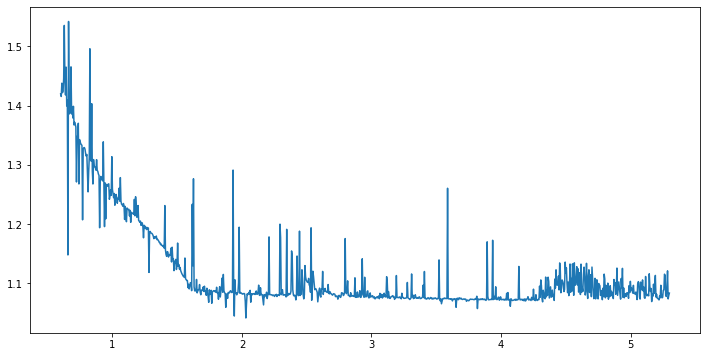

In [17]:
pl.figure(figsize=(12, 6))
pl.plot(wl, data[:,49107], '-')
#pl.xlim(0, 5)
#pl.ylim(0, 10)

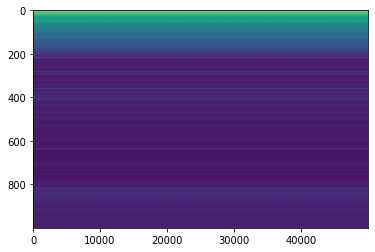

In [18]:
pl.imshow(data, aspect='auto')

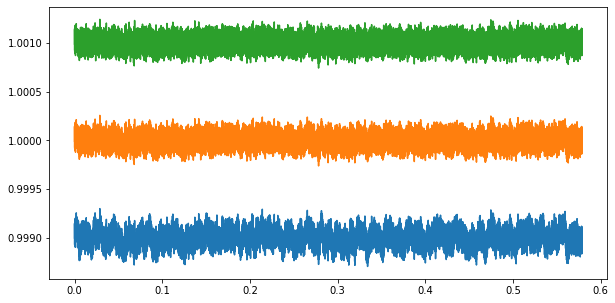

In [24]:
b1 = np.sum(data[1:100], axis=0)
b2 = np.sum(data[100:300], axis=0)
b3 = np.sum(data[300:], axis=0)

wn = np.random.randn(len(b1)) * 60 * 1e-6

pl.figure(figsize=(10, 5))
pl.plot(t, b1/np.mean(b1) + wn - 0.001, '-')
pl.plot(t, b2/np.mean(b2) + wn, '-')
pl.plot(t, b3/np.mean(b3) + wn + 0.001, '-')

In [20]:
len(data)

1000